<a href="https://colab.research.google.com/github/sujalgawas/csiro-biomass/blob/main/Biomass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import zipfile
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c csiro-biomass

100% 1.02G/1.02G [00:05<00:00, 152MB/s]
100% 1.02G/1.02G [00:05<00:00, 199MB/s]


In [3]:
import zipfile

zip_file_path = '/content/csiro-biomass.zip'
zip_file_dir = 'data'
with zipfile.ZipFile(zip_file_path,'r') as f:
  f.extractall(zip_file_dir)


In [4]:
import pandas as pd

train_df = pd.read_csv('/content/data/train.csv')
test_df = pd.read_csv('/content/data/test.csv')

In [5]:
train_df.head()

sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750

In [6]:
target_names = train_df['target_name'].unique()

In [7]:
print(target_names)

['Dry_Clover_g' 'Dry_Dead_g' 'Dry_Green_g' 'Dry_Total_g' 'GDM_g']


In [8]:
species = train_df['Species'].unique()

In [9]:
print(species)

['Ryegrass_Clover' 'Lucerne' 'SubcloverDalkeith' 'Ryegrass'
 'Phalaris_Clover' 'SubcloverLosa' 'Clover' 'Fescue_CrumbWeed'
 'Phalaris_Ryegrass_Clover' 'Phalaris' 'WhiteClover' 'Fescue'
 'Phalaris_BarleyGrass_SilverGrass_SpearGrass_Clover_Capeweed'
 'Phalaris_Clover_Ryegrass_Barleygrass_Bromegrass' 'Mixed']


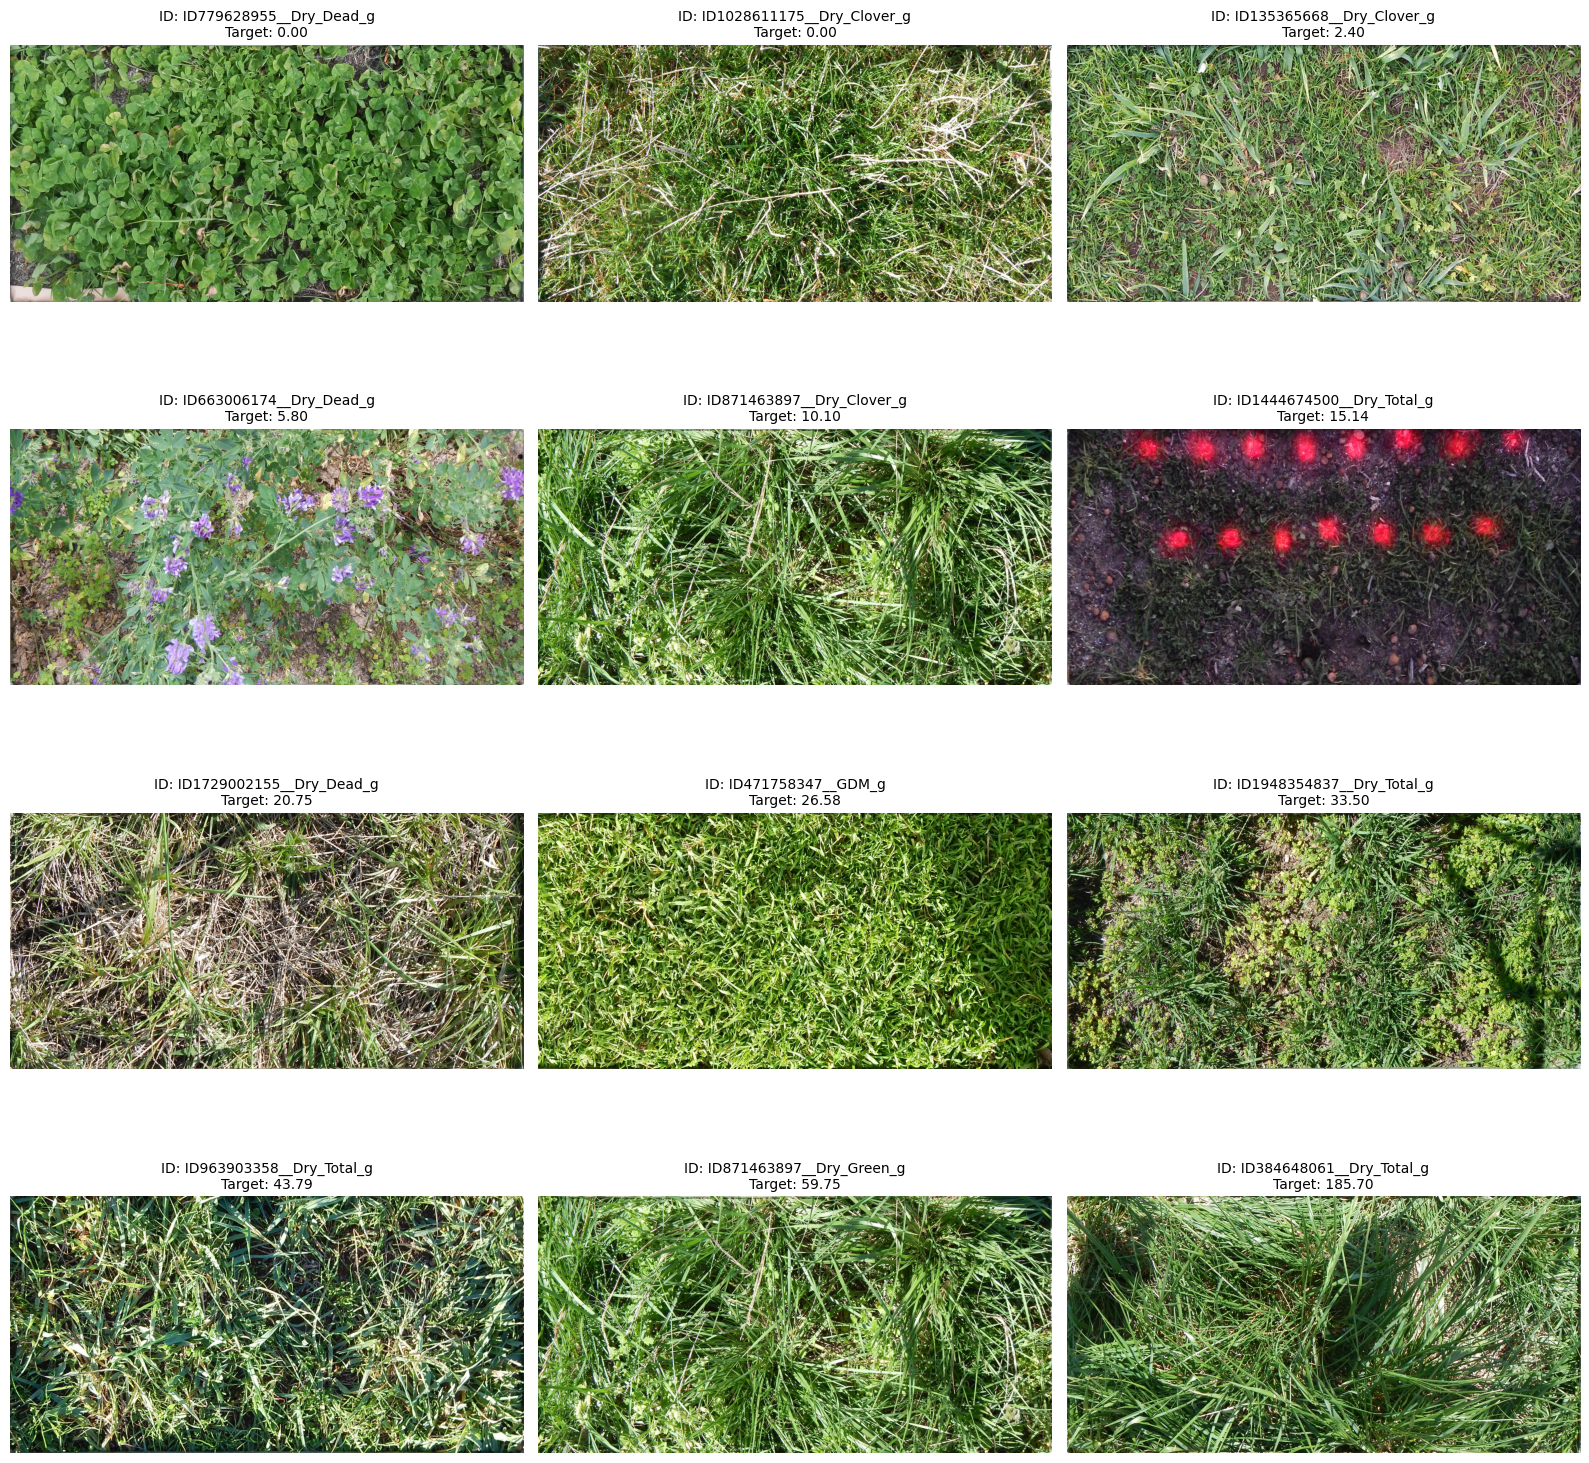

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

PATH_DATA = '/content/data'

def show_images(df_sample, n=12, path_img=PATH_DATA):
    """Displays a linear sampling of images sorted by target value."""

    df_sorted = df_sample.sort_values(by='target').reset_index(drop=True)

    indices_to_show = np.linspace(0, len(df_sorted) - 1, n, dtype=int)
    df_to_show = df_sorted.iloc[indices_to_show]

    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    for i in range(n, len(axes)):
        fig.delaxes(axes[i])

    for i, (idx, row) in enumerate(df_to_show.iterrows()):
        img_path = os.path.join(path_img, row['image_path'])

        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)
            title = f"ID: {row['sample_id']}\nTarget: {row['target']:.2f}"
            axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Show 12 images linearly sampled based on target value
show_images(train_df, n=12)

In [11]:
test = train_df[train_df['image_path'] == 'train/ID1011485656.jpg']
test

sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750

In [12]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 56.0 MB/s eta 0:00:00


creating Dataset with tabluar values, target and image

In [13]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import pandas as pd

def prepare_dataframe(df):
    df = df.copy()
    encoder = LabelEncoder()
    categorical_cols = ['State', 'Species', 'target_name']
    for col in categorical_cols:
        if col in df.columns:
            df[col] = encoder.fit_transform(df[col].astype(str))
    return df

class BiomassDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.tabular_data = dataframe
        self.root_dir = root_dir
        self.transform = transform

        # DEFINING COLUMNS HARDCODED
        # This ensures we always get exactly 5 columns.
        # If a column is missing, we WANT it to crash so we know the data is wrong.
        self.target_cols = ['State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name']

    def __len__(self):
        return len(self.tabular_data)

    def __getitem__(self, index):
        row = self.tabular_data.iloc[index]

        # 1. Image Handling
        img_path = os.path.join(self.root_dir, row['image_path'])
        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError):
            image = Image.new('RGB', (224, 224))

        if self.transform:
            image = self.transform(image)

        # 2. Tabular Handling (FIXED)
        # We enforce selecting exactly these 5 columns.
        # This guarantees the shape is always [5]
        features = row[self.target_cols].values.astype(float)
        tabular_features = torch.tensor(features, dtype=torch.float32)

        #trying sigmoid
        scaled_value = row['target']/35.0

        # 3. Label
        label = torch.tensor(scaled_value, dtype=torch.float32)

        return image, tabular_features, label

model architecture with basic pyotch model

In [14]:
"""
class BiomassDataModule(pl.LightningDataModule):
    def __init__(self, train_df, valid_df, root_dir, batch_size=16, num_workers=1):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = 224

    def setup(self, stage=None):
        train_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        valid_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.train_ds = BiomassDataset(self.train_df, self.root_dir, transform=train_transform)
        self.valid_ds = BiomassDataset(self.valid_df, self.root_dir, transform=valid_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )
        """

'\nclass BiomassDataModule(pl.LightningDataModule):\n    def __init__(self, train_df, valid_df, root_dir, batch_size=16, num_workers=1):\n        super().__init__()\n        self.train_df = train_df\n        self.valid_df = valid_df\n        self.root_dir = root_dir\n        self.batch_size = batch_size\n        self.num_workers = num_workers\n        self.img_size = 224\n\n    def setup(self, stage=None):\n        train_transform = transforms.Compose([\n            transforms.Resize((self.img_size, self.img_size)),\n            transforms.RandomHorizontalFlip(p=0.5),\n            transforms.ToTensor(),\n            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n        ])\n\n        valid_transform = transforms.Compose([\n            transforms.Resize((self.img_size, self.img_size)),\n            transforms.ToTensor(),\n            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n        ])\n\n        self.train_ds = BiomassDataset(self.train_df

Data module

In [15]:
class BiomassDataModule(pl.LightningDataModule):
    def __init__(self, train_df, valid_df, root_dir, batch_size=16, num_workers=1):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.img_size = 224 # Standard size

    def setup(self, stage=None):
        train_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        valid_transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        self.train_ds = BiomassDataset(self.train_df, self.root_dir, transform=train_transform)
        self.valid_ds = BiomassDataset(self.valid_df, self.root_dir, transform=valid_transform)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers
        )

# basic Model/template for biomass model

In [16]:
class BasicModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        # 1. Image Flatten Size (224x224x3) = 150528
        self.img_dim = 224 * 224 * 3

        # 2. Tabular Features Size = 5
        # (Must match the list in BiomassDataset exactly)
        self.tab_dim = 5

        # 3. Total Input Dimension
        # 150528 + 5 = 150533
        self.total_input_dim = self.img_dim + self.tab_dim

        self.model = nn.Sequential(
            # Input size must be 150533
            nn.Linear(self.total_input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        self.loss_fn = nn.L1Loss()

    def forward(self, x, tab_features):
        # Flatten Image: (Batch, 3, 224, 224) -> (Batch, 150528)
        x_flat = x.view(x.size(0), -1)

        # Concatenate: (Batch, 150528) + (Batch, 5) -> (Batch, 150533)
        combined = torch.cat((x_flat, tab_features), dim=1)

        return self.model(combined)

    def training_step(self, batch, batch_idx):
        x, tab, y = batch # y is now scaled (0.0 to 1.0)

        preds = self(x, tab) # preds is now scaled (0.0 to 1.0 via Sigmoid)

        # 1. Calculate optimization loss (Computer needs this 0-1 scale to learn safely)
        # We KEEP view(-1) to fix dimensions
        loss = self.loss_fn(preds.view(-1), y.view(-1))

        # 2. Calculate Real-World Error (You need this to track progress)
        # Multiply back by the max value (35.0) to get real units
        with torch.no_grad(): # Don't track gradients for this math
            real_pred = preds.view(-1) * 35.0
            real_y = y.view(-1) * 35.0
            real_mae = torch.nn.L1Loss()(real_pred, real_y)

        # Log both
        self.log("train_loss", loss, prog_bar=True)      # The small number (0.05)
        self.log("train_real_mae", real_mae, prog_bar=True) # The real number (1.75)

        return loss

    def validation_step(self, batch, batch_idx):
        x, tab, y = batch # y is scaled (0 to 1)
        preds = self(x, tab) # preds is scaled (0 to 1)

        # Calculate loss on the SCALED values for stability
        loss = self.loss_fn(preds.view(-1), y.view(-1))
        self.log("val_loss_scaled", loss, prog_bar=True)

        # CALCULATE REAL WORLD ERROR (For you to see)
        real_pred = preds.view(-1) * 35.0
        real_y = y.view(-1) * 35.0
        real_mae = torch.nn.L1Loss()(real_pred, real_y)
        self.log("REAL_MAE", real_mae, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

Training

In [17]:
# Preprocess
df_clean = prepare_dataframe(train_df)

# Create dummy images so code doesn't crash
os.makedirs('/content/data', exist_ok=True)
for p in train_df['image_path']:
    Image.new('RGB', (224, 224)).save(os.path.join('/content/data', p))

# Split data
train_df = df_clean.iloc[:3]
valid_df = df_clean.iloc[3:]

# --- INITIALIZE MODULES ---

data_module = BiomassDataModule(
    train_df=train_df,
    valid_df=valid_df,
    root_dir='/content/data', # Pointing to our dummy data folder
    batch_size=32
)

In [33]:
model = BasicModel(lr=1e-3)

# --- TRAINER SETUP ---

# Initialize trainer
# limit_train_batches is just for this fast test run
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='auto', # Uses GPU if available, else CPU
    devices=1,
    log_every_n_steps=1
)

print("--- Starting Training ---")
trainer.fit(model, data_module)
print("--- Training Finished ---")

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 19.3 M | train
1 | loss_fn | L1Loss     | 0      | train
-----------------------------------------------
19.3 M    Trainable params
0         Non-trainable params
19.3 M    Total params
77.074    Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


--- Starting Training ---


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:106: Total length of `DataLoader` across ranks is zero. Please make sure this was your intention.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


--- Training Finished ---


In [34]:
# Validate explicitly to see the final validation score
print("--- Running Validation ---")
trainer.validate(model, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Running Validation ---


[]

# Model using Resnet50

In [31]:
import torchvision.models as models

class resnetBiomas(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # 1. don't need to flatten the image
        self.img_dim = self.resnet.fc.in_features

        self.resnet.fc = nn.Identity()

        # 2. Tabular Features Size = 5
        # (Must match the list in BiomassDataset exactly)
        self.tab_dim = 5

        # 3. Total Input Dimension
        # 2048 + 5 = 2053
        self.total_input_dim = self.img_dim + self.tab_dim

        self.model = nn.Sequential(
            # Layer 1
            # Input size must be 2053
            nn.Linear(self.total_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Layer 2
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),

            # Output Layer
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        self.loss_fn = nn.L1Loss()

    def forward(self, x, tab_features):
        x = self.resnet(x)

        #don't need to flatten for resnet50
        # Flatten Image: (Batch, 3, 224, 224) -> (Batch, 150528)
        #x_flat = x.view(x.size(0), -1)

        # Concatenate: (Batch, 150528) + (Batch, 5) -> (Batch, 150533)
        combined = torch.cat((x, tab_features), dim=1)

        return self.model(combined)

    def training_step(self, batch, batch_idx):
        x, tab, y = batch # y is now scaled (0.0 to 1.0)

        preds = self(x, tab) # preds is now scaled (0.0 to 1.0 via Sigmoid)

        # 1. Calculate optimization loss (Computer needs this 0-1 scale to learn safely)
        # We KEEP view(-1) to fix dimensions
        loss = self.loss_fn(preds.view(-1), y.view(-1))

        # 2. Calculate Real-World Error (You need this to track progress)
        # Multiply back by the max value (35.0) to get real units
        with torch.no_grad(): # Don't track gradients for this math
            real_pred = preds.view(-1) * 35.0
            real_y = y.view(-1) * 35.0
            real_mae = torch.nn.L1Loss()(real_pred, real_y)

        # Log both
        self.log("train_loss", loss, prog_bar=True)      # The small number (0.05)
        self.log("train_real_mae", real_mae, prog_bar=True) # The real number (1.75)

        return loss

    def validation_step(self, batch, batch_idx):
        x, tab, y = batch # y is scaled (0 to 1)
        preds = self(x, tab) # preds is scaled (0 to 1)

        # Calculate loss on the SCALED values for stability
        loss = self.loss_fn(preds.view(-1), y.view(-1))
        self.log("val_loss_scaled", loss, prog_bar=True)

        # CALCULATE REAL WORLD ERROR (For you to see)
        real_pred = preds.view(-1) * 35.0
        real_y = y.view(-1) * 35.0
        real_mae = torch.nn.L1Loss()(real_pred, real_y)
        self.log("REAL_MAE", real_mae, prog_bar=True)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [32]:
model_1 = resnetBiomas(lr=1e-8)

trainer_1 = pl.Trainer(
    max_epochs=10,
    accelerator='auto', # Uses GPU if available, else CPU
    devices=1,
    log_every_n_steps=1
)

trainer_1.fit(model_1, data_module)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | resnet  | ResNet     | 23.5 M | train
1 | model   | Sequential | 271 K  | train
2 | loss_fn | L1Loss     | 0      | train
-----------------------------------------------
23.8 M    Trainable params
0         Non-trainable params
23.8 M    Total params
95.117    Total estimated model params size (MB)
161       Modules in train mode
0         Modules in eval mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
trainer_1.validate(model_1,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         REAL_MAE          │    18.710161209106445     │
│      val_loss_scaled      │    0.5345759391784668     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss_scaled': 0.5345759391784668, 'REAL_MAE': 18.710161209106445}]

In [35]:
print("Max Target:", train_df['target'].max())
print("Min Target:", train_df['target'].min())
print("Mean Target:", train_df['target'].mean())

Max Target: 31.9984
Min Target: 0.0
Mean Target: 16.091166666666666
